In [1]:
import os
import json
import PIL
from matplotlib import pyplot as plt

import numpy as np


from keras.callbacks import ModelCheckpoint
from keras.layers import GlobalAveragePooling2D, Activation, Input, Flatten
from keras.models import Model
from keras.utils.np_utils import to_categorical
from keras.preprocessing import image

from vgg16bn import Vgg16BN

Using TensorFlow backend.


In [2]:
ROOT_DIR = os.getcwd()
DATA_HOME_DIR = ROOT_DIR + '/data'
%matplotlib inline

In [3]:
# paths
data_path = DATA_HOME_DIR + '' 
split_train_path = data_path + '/train/'
full_train_path = data_path + '/train_full/'
valid_path = data_path + '/valid/'
test_path = DATA_HOME_DIR + '/test/'
submission_path = 'submissions/bb_multi_input/'

# data
batch_size = 32
nb_split_train_samples = 3277
nb_full_train_samples = 3785
nb_valid_samples = 500
nb_test_samples = 1000
classes = ["ALB", "BET", "DOL", "LAG", "NoF", "OTHER", "SHARK", "YFT"]
nb_classes = len(classes)

# model
nb_epoch = 5
n_filters = 128
lr = 1e-3
dropout = 0.4
clip = 0.01

In [4]:
def get_batches(dirname, gen=image.ImageDataGenerator(), shuffle=True,
                batch_size=4, class_mode='categorical', target_size=(244, 244)):
    return gen.flow_from_directory(
        dirname,
        target_size=target_size,
        class_mode=class_mode,
        shuffle=shuffle,
        batch_size=batch_size,
    )

def get_data(path, target_size=(224,224)):
    batches = get_batches(path, shuffle=False, batch_size=1, class_mode=None, target_size=target_size)
    return np.concatenate([batches.next() for i in range(batches.nb_sample)])


In [5]:
def get_classes(trn_path, val_path, test_path):
    batches = get_batches(trn_path,
                          shuffle=False,
                          batch_size=1,
                          target_size=(360, 640))
    val_batches = get_batches(val_path, shuffle=False, batch_size=1, target_size=(360, 640))
    test_batches = get_batches(test_path, shuffle=False, batch_size=1, target_size=(360, 640))
    return (
        val_batches.classes,
        batches.classes,
        to_categorical(val_batches.classes),
        to_categorical(batches.classes),        
        val_batches.filenames,
        batches.filenames,
        test_batches.filenames)

In [6]:
(
    val_classes, trn_classes,
    val_labels, trn_labels, 
    val_filenames, filenames, test_filenames
) = get_classes(
        split_train_path,
        valid_path,
        test_path,
)

Found 3277 images belonging to 8 classes.
Found 500 images belonging to 8 classes.
Found 1000 images belonging to 1 classes.


In [7]:
raw_filenames = [f.split('/')[-1] for f in filenames]
raw_test_filenames = [f.split('/')[-1] for f in test_filenames]
raw_val_filenames = [f.split('/')[-1] for f in val_filenames]

In [47]:
# WARNING, loading the training dataset will consume a LOT of RAM and crash
#trn = get_data(split_train_path, target_size=(360, 640))
val = get_data(valid_path, target_size=(360, 640))

Found 500 images belonging to 8 classes.


In [9]:
anno_classes = ['alb', 'bet', 'dol', 'lag', 'other', 'shark', 'yft']

In [10]:

bb_json = {}
for c in anno_classes:
    j = json.load(open('bb_annotations/{}.json'.format(c), 'r'))
    for l in j:
        if 'annotations' in l.keys() and len(l['annotations'])>0:
            bb_json[l['filename'].split('/')[-1]] = sorted(
                l['annotations'], key=lambda x: x['height']*x['width'])[-1]
            

bb_json['img_04908.jpg']

{u'class': u'rect',
 u'height': 246.75000000000074,
 u'width': 432.8700000000013,
 u'x': 465.3000000000014,
 u'y': 496.32000000000147}

In [108]:
file2idx = {o:i for i,o in enumerate(raw_filenames)}
val_file2idx = {o:i for i,o in enumerate(raw_val_filenames)}

raw_val_filenames[101]

'img_00003.jpg'

In [12]:
empty_bbox = {'height': 0., 'width': 0., 'x': 0., 'y': 0.}

In [45]:

for f in raw_filenames:
    if not f in bb_json.keys():
        bb_json[f] = empty_bbox
for f in raw_val_filenames:
    if not f in bb_json.keys():
        bb_json[f] = empty_bbox
        
bb_json['img_00301.jpg']

{u'class': u'rect',
 u'height': 109.98000000000167,
 u'width': 322.89000000000493,
 u'x': 335.5800000000051,
 u'y': 228.42000000000348}

In [14]:
bb_params = ['height', 'width', 'x', 'y']
def convert_bb(bb, size):
    bb = [bb[p] for p in bb_params]
    conv_x = (640. / size[0])
    conv_y = (360. / size[1])
    bb[0] = bb[0]*conv_y
    bb[1] = bb[1]*conv_x
    bb[2] = max(bb[2]*conv_x, 0)
    bb[3] = max(bb[3]*conv_y, 0)
    return bb

In [54]:
sizes = [PIL.Image.open(full_train_path + f).size for f in val_filenames]
id2size = list(set(sizes))
size2id = {o:i for i,o in enumerate(id2size)}
val_filenames

['ALB/img_00301.jpg',
 'ALB/img_00154.jpg',
 'ALB/img_00015.jpg',
 'ALB/img_00496.jpg',
 'ALB/img_00299.jpg',
 'ALB/img_00461.jpg',
 'ALB/img_00163.jpg',
 'ALB/img_00317.jpg',
 'ALB/img_00236.jpg',
 'ALB/img_00576.jpg',
 'ALB/img_00121.jpg',
 'ALB/img_00177.jpg',
 'ALB/img_00425.jpg',
 'ALB/img_00211.jpg',
 'ALB/img_00546.jpg',
 'ALB/img_00415.jpg',
 'ALB/img_00186.jpg',
 'ALB/img_00525.jpg',
 'ALB/img_00545.jpg',
 'ALB/img_00233.jpg',
 'ALB/img_00466.jpg',
 'ALB/img_00191.jpg',
 'ALB/img_00366.jpg',
 'ALB/img_00579.jpg',
 'ALB/img_00342.jpg',
 'ALB/img_00570.jpg',
 'ALB/img_00032.jpg',
 'ALB/img_00558.jpg',
 'ALB/img_00019.jpg',
 'ALB/img_00020.jpg',
 'ALB/img_00201.jpg',
 'ALB/img_00353.jpg',
 'ALB/img_00523.jpg',
 'ALB/img_00057.jpg',
 'ALB/img_00208.jpg',
 'ALB/img_00508.jpg',
 'ALB/img_00482.jpg',
 'ALB/img_00188.jpg',
 'ALB/img_00248.jpg',
 'ALB/img_00502.jpg',
 'ALB/img_00156.jpg',
 'ALB/img_00237.jpg',
 'ALB/img_00097.jpg',
 'ALB/img_00507.jpg',
 'ALB/img_00239.jpg',
 'ALB/img_

In [55]:
trn_sizes_orig = to_categorical([size2id[o] for o in sizes], len(id2size))
raw_val_sizes = [PIL.Image.open(valid_path + f).size for f in val_filenames]

val_sizes = to_categorical([size2id[o] for o in raw_val_sizes], len(id2size))
trn_sizes = trn_sizes_orig-trn_sizes_orig.mean(axis=0)/trn_sizes_orig.std(axis=0)
val_sizes = val_sizes-trn_sizes_orig.mean(axis=0)/trn_sizes_orig.std(axis=0)

In [56]:
trn_bbox = np.stack(
    [convert_bb(bb_json[f], s) 
     for f, s in zip(raw_val_filenames, sizes)]
).astype(np.float32)

val_bbox = np.stack(
    [convert_bb(bb_json[f], s)
     for f, s in zip(raw_val_filenames, raw_val_sizes)]
).astype(np.float32)

In [99]:
def plot(img):
    plt.imshow(np.rollaxis(img, 0, 1).astype(np.uint8))
img = val[0]
img.shape

#with this you can select a color from the img
#lum_img = img[:,:,2]
#lum_img.shape
#plt.imshow(lum_img)

(360, 640, 3)

In [100]:
def create_rect(bb, color='red'):
    return plt.Rectangle((bb[2], bb[3]), bb[1], bb[0], color=color, fill=False, lw=3)


def show_bb(i):
    bb = val_bbox[i]
    plot(val[i])
    plt.gca().add_patch(create_rect(bb))

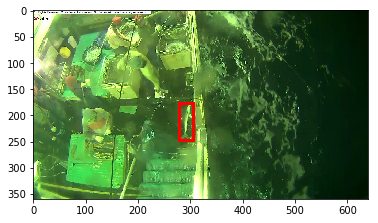

In [101]:
show_bb(432)